<a href="https://colab.research.google.com/github/Atfssene/FRASA/blob/main/IndoSum_EDA_FRASA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IndoSum Dataset EDA**
**Potato Tech** team build an app that named **Frasa** for capstone project. So we will build machine learning model for Frasa to predict a summary from a sentences.

In this lab, we will do exploratory data analysis and preprocess the dataset.
The dataset is consists of news articles and manually constructed summaries [IndoSum dataset](https://drive.google.com/file/d/1OgYbPfXFAv3TbwP1Qcwt_CC9cVWSJaco/view) from [Kurniawan, Kemal & Louvan, Samuel (2018)](https://arxiv.org/abs/1810.05334).

Let's start!

## Preparation

In [6]:
!pip install Sastrawi
import nltk
nltk.download('punkt')

In [37]:
# Import library
import pandas as pd
import json
import matplotlib.pyplot as plt
import re
import networkx as nx
import seaborn as sns
import numpy as np

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer as untoken
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.metrics.pairwise import cosine_similarity

factory = StopWordRemoverFactory()
stop_words = factory.get_stop_words()

## Load data

In [8]:
# Download and extract the dataset
!gdown --id 1OgYbPfXFAv3TbwP1Qcwt_CC9cVWSJaco
!tar -xvf /content/indosum.tar.gz

Downloading...
From: https://drive.google.com/uc?id=1OgYbPfXFAv3TbwP1Qcwt_CC9cVWSJaco
To: /content/indosum.tar.gz
96.0MB [00:00, 187MB/s]
indosum/
indosum/test.02.jsonl
indosum/README.txt
indosum/train.05.jsonl
indosum/train.04.jsonl
indosum/test.04.jsonl
indosum/train.01.jsonl
indosum/test.05.jsonl
indosum/test.03.jsonl
indosum/test.01.jsonl
indosum/dev.04.jsonl
indosum/dev.01.jsonl
indosum/dev.02.jsonl
indosum/train.02.jsonl
indosum/dev.03.jsonl
indosum/dev.05.jsonl
indosum/CHANGELOG.txt
indosum/train.03.jsonl


In [9]:
# We will use the first-fold data (train, dev, test)
files=['/content/indosum/train.01.jsonl',
       '/content/indosum/dev.01.jsonl',
       '/content/indosum/test.01.jsonl']

with open(files[0], 'r') as f, open(files[1], 'r') as ft, open(files[2], 'r') as ftest:
  data_train = f.readlines()
  data_train = list(map(json.loads, data_train))
  data_dev = ft.readlines()
  data_dev = list(map(json.loads, data_dev))
  df1 = pd.DataFrame(data_train)
  df2 = pd.DataFrame(data_dev)

  data_test = ftest.readlines()
  data_test = list(map(json.loads, data_test))

test = pd.DataFrame(data_test)
train = pd.concat([df1, df2])


## Exploratoratory

In [10]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15012 entries, 0 to 749
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   category     15012 non-null  object
 1   gold_labels  15012 non-null  object
 2   id           15012 non-null  object
 3   paragraphs   15012 non-null  object
 4   source       15012 non-null  object
 5   source_url   15012 non-null  object
 6   summary      15012 non-null  object
dtypes: object(7)
memory usage: 938.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3762 entries, 0 to 3761
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   category     3762 non-null   object
 1   gold_labels  3762 non-null   object
 2   id           3762 non-null   object
 3   paragraphs   3762 non-null   object
 4   source       3762 non-null   object
 5   source_url   3762 non-null   object
 6   summary      3762 non-null   object
dty

Now we know the dataset consist of 7 columns and probably we will just take some of the column that related to this summarization work.

To make we sure what columns should we choose, let's take a look at some rows.

In [11]:
train.head()

,category,gold_labels,id,paragraphs,source,source_url,summary
0,tajuk utama,"[[False, True], [True, True], [False, False, F...",1501893029-lula-kamal-dokter-ryan-thamrin-saki...,"[[[Jakarta, ,, CNN, Indonesia, -, -, Dokter, R...",cnn indonesia,https://www.cnnindonesia.com/hiburan/201708041...,"[[Dokter, Lula, Kamal, yang, merupakan, selebr..."
1,teknologi,"[[False, False, False, False], [False, True, T...",1509072914-dua-smartphone-zenfone-baru-tawarka...,"[[[Selfie, ialah, salah, satu, tema, terpanas,...",dailysocial.id,https://dailysocial.id/post/dua-smartphone-zen...,"[[Asus, memperkenalkan, , ZenFone, generasi, ..."
2,hiburan,"[[True], [True], [False, False], [False], [Fal...",1510613677-songsong-visit-2020-bengkulu-perkua...,"[[[Jakarta, ,, CNN, Indonesia, -, -, Dinas, Pa...",cnn indonesia,https://www.cnnindonesia.com/gaya-hidup/201711...,"[[Dinas, Pariwisata, Provinsi, Bengkulu, kemba..."
3,tajuk utama,"[[True, True], [False, False, False], [True], ...",1502706803-icw-ada-kejanggalan-atas-tewasnya-s...,"[[[Merdeka.com, -, Indonesia, Corruption, Watc...",merdeka,https://www.merdeka.com/peristiwa/icw-merasa-a...,"[[Indonesia, Corruption, Watch, (, ICW, ), mem..."
4,tajuk utama,"[[False, True], [True, True, True], [False], [...",1503039338-pembagian-sepeda-usai-upacara-penur...,"[[[Merdeka.com, -, Presiden, Joko, Widodo, (, ...",merdeka,https://www.merdeka.com/peristiwa/usai-upacara...,"[[Jokowi, memimpin, upacara, penurunan, bender..."


From here, we can see our raw data have:

1. Tokenized paragraphs and summary.
2. Punctuation wasn't cleaned.
3. Uncased letters.
3. Column gold_labels is a boolean list of main idea sentences in paragraphs
4. This dataset (train+dev set)  had 7 columns and 15012 rows.

For next, the columns will be used are **gold_labels, paragraphs**, and **summary**.


## Preprocess #1

We will flatten the three columns as instead tokenized string/listed because our predict input later could be raw string.

In [12]:
def untokenizer(dataframe_row, axis):
  text_list = []
  for data in dataframe_row:
    string = ""
    if axis == 0:
      for t in data:
        for text in t:
          string = string + untoken().detokenize(text) + " "
    elif axis == 1:
      for text in data:
          string = string + untoken().detokenize(text) + " "
    else:
      string =  [y for x in data for y in x]

    text_list.append(string)
  return text_list

In [13]:
train['paragraphs'] = untokenizer(train['paragraphs'], 0)
train['summary'] = untokenizer(train['summary'], 1)
train['labels'] = untokenizer(train['gold_labels'], 2)

test['paragraphs'] = untokenizer(test['paragraphs'], 0)
test['summary'] = untokenizer(test['summary'], 1)
test['labels'] = untokenizer(test['gold_labels'], 2)

In [14]:
pd.set_option('display.max_columns', None)
pd.set_option("display.max_colwidth", None)

train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15012 entries, 0 to 749
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   category     15012 non-null  object
 1   gold_labels  15012 non-null  object
 2   id           15012 non-null  object
 3   paragraphs   15012 non-null  object
 4   source       15012 non-null  object
 5   source_url   15012 non-null  object
 6   summary      15012 non-null  object
 7   labels       15012 non-null  object
dtypes: object(8)
memory usage: 1.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3762 entries, 0 to 3761
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   category     3762 non-null   object
 1   gold_labels  3762 non-null   object
 2   id           3762 non-null   object
 3   paragraphs   3762 non-null   object
 4   source       3762 non-null   object
 5   source_url   3762 non-null   object
 6   summa

In [15]:
columns = ['labels','paragraphs', 'summary']
train[columns].head(2)

labels  \
0                                                                                                                                                            [False, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False]   
1  [False, False, False, False, False, True, True, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

That's better! Before continue preprocesing data, let's check if it have empty value or duplicate value.

In [16]:
train.isnull().any()

category       False
gold_labels    False
id             False
paragraphs     False
source         False
source_url     False
summary        False
labels         False
dtype: bool

In [17]:
test.isnull().any()

category       False
gold_labels    False
id             False
paragraphs     False
source         False
source_url     False
summary        False
labels         False
dtype: bool

In [18]:
train[train['paragraphs'].duplicated()]

,category,gold_labels,id,paragraphs,source,source_url,summary,labels


In [19]:
test[test['paragraphs'].duplicated()]

,category,gold_labels,id,paragraphs,source,source_url,summary,labels


Great!

No empty value and no duplicate value from **15012 rows** train data and **3762 rows** test data.
Let's explore again our data and create preprocessing.

### Sentences & Words Length

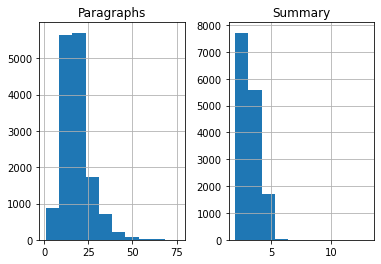

In [20]:
paragraphs_sentences = []
summary_sentences = []

# populate the lists with sentence lengths
for t in train['paragraphs']:
      paragraphs_sentences.append(len(sent_tokenize(t)))

# populate the lists with sentence lengths
for t in train['summary']:
      summary_sentences.append(len(sent_tokenize(t)))

sentences_hist = pd.DataFrame({'Paragraphs':paragraphs_sentences, 'Summary':summary_sentences})

sentences_hist.hist()
plt.show()

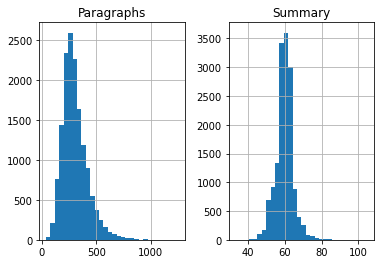

In [21]:
paragraphs_words = []
summary_words = []

# populate the lists with sentence lengths
for t in train['paragraphs']:
      paragraphs_words.append(len(t.split()))

# populate the lists with sentence lengths
for t in train['summary']:
      summary_words.append(len(t.split()))

words_hist = pd.DataFrame({'Paragraphs':paragraphs_words, 'Summary':summary_words})

words_hist.hist(bins=30)
plt.show()

So the number of sentences in the paragraph is around 15-20 sentences while the summary mostly have less than 5 sentences.

For words, paragraphs have around 250 words and summaries have 60 words.

# Extract Features

We will create a model for text summarization task. TextRank and SumBasic will be our feature extraction from senteces to create insight what model should we build. Let's start!

## TextRank

Load pretrained words embeddings:

In [5]:
# Download pretrained word embedding vector
!gdown --id 1FbCFQa8wuNZdEX_RdQEzqPnRC3wRI6Kk

Downloading...
From: https://drive.google.com/uc?id=1FbCFQa8wuNZdEX_RdQEzqPnRC3wRI6Kk
To: /content/cc.id.vec
890MB [00:09, 89.8MB/s]


In [26]:
word_embeddings = {}
with open('/content/cc.id.vec', encoding='utf-8') as file:
  for f in file:
      values = f.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      word_embeddings[word] = coefs

len(word_embeddings)

400001

TextRank Algorithm

In [27]:
# For sorting return list
def sorting(e):
    return e[2]

# TextRank algorithm
def TextRank(sentences, processed):
    sentence_vectors = []
    for i in processed:
      if len(i) != 0:
        v = sum([word_embeddings.get(w, np.zeros((300,))) for w in i.split()])/(len(i.split())+0.001)
      else:
        v = np.zeros((300,))
      sentence_vectors.append(v)

    sim_mat = np.zeros([len(sentences), len(sentences)])
    for i in range(len(sentences)):
      for j in range(len(sentences)):
        if i != j:
          sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,300), sentence_vectors[j].reshape(1,300))[0,0]

    nx_graph = nx.from_numpy_array(sim_mat)
    scores = nx.pagerank_numpy(nx_graph)

    ranked_sentences = sorted(([scores[i],i+1,s] for i,s in enumerate(sentences)), reverse=True)

    text_rank = []
    for index, sentence in enumerate(ranked_sentences):
      sentence.insert(1, index+1)
      text_rank.append(sentence)

    # Return list(TextRank weights, TextRank order, sentence order, sentence) => text_rank
    text_rank = sorted(text_rank,key=sorting)

    TR_weight = []
    TR_order = []
    for i in range(len(text_rank)):
      TR_weight.append(text_rank[i][0])
      TR_order.append(text_rank[i][1])
    # Just Return 2 list(TextRank weights, TextRank order)
    return TR_weight, TR_order

Example result from variable text_rank:


```
[0.05728266277281181, 7, 1, 'Jakarta, CNN Indonesia - - Dokter Ryan Thamrin, yang terkenal lewat acara Dokter Oz Indonesia, meninggal dunia pada Jumat (4 / 8) dini hari.']
[0.060217967742173646, 2, 2, 'Dokter Lula Kamal yang merupakan selebriti sekaligus rekan kerja Ryan menyebut kawannya itu sudah sakit sejak setahun yang lalu.']
[0.06045704497658339, 1, 3, 'Lula menuturkan, sakit itu membuat Ryan mesti vakum dari semua kegiatannya, termasuk menjadi pembawa acara Dokter Oz Indonesia.']
[0.05209530959721178, 15, 4, 'Kondisi itu membuat Ryan harus kembali ke kampung halamannya di Pekanbaru, Riau untuk menjalani istirahat. "']
[0.05840185989845859, 4, 5, 'Setahu saya dia orangnya sehat, tapi tahun lalu saya dengar dia sakit.']
[0.05637943589724592, 10, 6, '( Karena) sakitnya, ia langsung pulang ke Pekanbaru, jadi kami yang mau jenguk juga susah.']
[0.05646634343163575, 9, 7, 'Barangkali mau istirahat, ya betul juga, kalau di Jakarta susah isirahatnya, " kata Lula kepada CNNIndonesia.com, Jumat (4 / 8).']
[0.058732876811454365, 3, 8, 'Lula yang mengenal Ryan sejak sebelum aktif berkarier di televisi mengaku belum sempat membesuk Ryan lantaran lokasi yang jauh.']
[0.055390279489910994, 12, 9, 'Dia juga tak tahu penyakit apa yang diderita Ryan. "']
[0.053688773306564144, 14, 10, 'Itu saya enggak tahu, belum sempat jenguk dan enggak selamanya bisa dijenguk juga.']
[0.05747455457427858, 6, 11, 'Enggak tahu berat sekali apa bagaimana, " tutur Ryan.']
[0.055102006046349405, 13, 12, 'Walau sudah setahun menderita sakit, Lula tak mengetahui apa penyebab pasti kematian Dr Oz Indonesia itu.']
[0.05763968547747263, 5, 13, 'Meski demikian, ia mendengar beberapa kabar yang menyebut bahwa penyebab Ryan meninggal adalah karena jatuh di kamar mandi.']
[0.05690594567038913, 8, 14, '“ Saya tidak tahu, barangkali penyakit yang dulu sama yang sekarang berbeda, atau penyebab kematiannya beda dari penyakit sebelumnya.']
[0.048397823134637225, 18, 15, 'Kita kan enggak bisa mengambil kesimpulan, " kata Lula.']
[0.056112156670864166, 11, 16, 'Ryan Thamrin terkenal sebagai dokter yang rutin membagikan tips dan informasi kesehatan lewat tayangan Dokter Oz Indonesia.']
[0.04974842217789095, 16, 17, 'Ryan menempuh Pendidikan Dokter pada tahun 2002 di Fakultas Kedokteran Universitas Gadjah Mada.']
[0.049506852324067645, 17, 18, 'Dia kemudian melanjutkan pendidikan Klinis Kesehatan Reproduksi dan Penyakit Menular Seksual di Mahachulalongkornrajavidyalaya University, Bangkok, Thailand pada 2004.']
```



## SumBasic

In [28]:
def SumBasic(sentences, processed):
  # Count the sum weights
  frequency = {}
  for text in processed:
    for word in word_tokenize(text):
      if word not in frequency.keys():
        frequency[word]=1
      else:
        frequency[word]+=1
  max_fre = max(frequency.values())
  for word in frequency.keys():
      frequency[word]=(frequency[word]/max_fre)
  
  # Score the weight for every sentence
  scores = {}
  sentence_count = 0
  sentence_len = []
  for i, sentence in enumerate(processed):
    if (len(sentence) != 0):
      for word in word_tokenize(sentence):  
        if word in frequency.keys():
            if i not in scores.keys():
              scores[i] = frequency[word]            
            else:
              scores[i] += frequency[word]
            sentence_count += 1
    else:
      scores[i] = 0.0000001
    sentence_len.append(sentence_count)
    sentence_count = 0

  ranked_sentences = sorted(([scores[i],i+1,s] for i,s in enumerate(sentences)), reverse=True)

  # Return list(SumBasic weights, SumBasic order, sentence order, sentence) => sum_bas
  sum_bas = []
  for index, sentence in enumerate(ranked_sentences):
    sentence.insert(1, index+1)
    sum_bas.append(sentence)

  sum_bas = sorted(sum_bas,key=sorting)

  SB_weight = []
  SB_order = []
  for i in range(len(sum_bas)):
    SB_weight.append(sum_bas[i][0])
    SB_order.append(sum_bas[i][1])
  # Just Return 2 list(TextRank weights, TextRank order)
  return SB_weight, SB_order, sentence_len

Example result from variable sum_bas :


```
[4.727272727272726, 1, 0, 'Jakarta, CNN Indonesia - - Dokter Ryan Thamrin, yang terkenal lewat acara Dokter Oz Indonesia, meninggal dunia pada Jumat (4 / 8) dini hari.']
[3.909090909090908, 4, 1, 'Dokter Lula Kamal yang merupakan selebriti sekaligus rekan kerja Ryan menyebut kawannya itu sudah sakit sejak setahun yang lalu.']
[4.09090909090909, 2, 2, 'Lula menuturkan, sakit itu membuat Ryan mesti vakum dari semua kegiatannya, termasuk menjadi pembawa acara Dokter Oz Indonesia.']
[1.9999999999999998, 12, 3, 'Kondisi itu membuat Ryan harus kembali ke kampung halamannya di Pekanbaru, Riau untuk menjalani istirahat. "']
[1.0909090909090908, 17, 4, 'Setahu saya dia orangnya sehat, tapi tahun lalu saya dengar dia sakit.']
[0.9090909090909092, 18, 5, '( Karena) sakitnya, ia langsung pulang ke Pekanbaru, jadi kami yang mau jenguk juga susah.']
[2.0, 11, 6, 'Barangkali mau istirahat, ya betul juga, kalau di Jakarta susah isirahatnya, " kata Lula kepada CNNIndonesia.com, Jumat (4 / 8).']
[3.7272727272727266, 5, 7, 'Lula yang mengenal Ryan sejak sebelum aktif berkarier di televisi mengaku belum sempat membesuk Ryan lantaran lokasi yang jauh.']
[1.8181818181818183, 13, 8, 'Dia juga tak tahu penyakit apa yang diderita Ryan. "']
[1.6363636363636362, 14, 9, 'Itu saya enggak tahu, belum sempat jenguk dan enggak selamanya bisa dijenguk juga.']
[2.090909090909091, 9, 10, 'Enggak tahu berat sekali apa bagaimana, " tutur Ryan.']
[2.0909090909090904, 10, 11, 'Walau sudah setahun menderita sakit, Lula tak mengetahui apa penyebab pasti kematian Dr Oz Indonesia itu.']
[2.2727272727272725, 7, 12, 'Meski demikian, ia mendengar beberapa kabar yang menyebut bahwa penyebab Ryan meninggal adalah karena jatuh di kamar mandi.']
[2.181818181818181, 8, 13, '“ Saya tidak tahu, barangkali penyakit yang dulu sama yang sekarang berbeda, atau penyebab kematiannya beda dari penyakit sebelumnya.']
[1.2727272727272727, 16, 14, 'Kita kan enggak bisa mengambil kesimpulan, " kata Lula.']
[3.9090909090909083, 3, 15, 'Ryan Thamrin terkenal sebagai dokter yang rutin membagikan tips dan informasi kesehatan lewat tayangan Dokter Oz Indonesia.']
[2.545454545454545, 6, 16, 'Ryan menempuh Pendidikan Dokter pada tahun 2002 di Fakultas Kedokteran Universitas Gadjah Mada.']
[1.636363636363636, 15, 17, 'Dia kemudian melanjutkan pendidikan Klinis Kesehatan Reproduksi dan Penyakit Menular Seksual di Mahachulalongkornrajavidyalaya University, Bangkok, Thailand pada 2004.']
```



## Text Cleaning

In [29]:
def Cleaning(rows):
  sentences = []
  processed = []
  for row in sent_tokenize(rows['paragraphs']):
    sentences.append(sent_tokenize(row))
  sentences = [y for x in sentences for y in x]
  # sentences = tokenize raw paragraph <list>

  for text in sentences:
    text = text.lower()
    text = re.sub(r"[^a-zA-Z]", " ", text)
    text = re.sub(r"\b\w{1,3}\b"," ",text)
    text = " ".join([word for word in text.split() if not word in stop_words])
    processed.append(text)
  # processed = tokenize cleaned text <list>
  return sentences, processed

## Preprocess #2

Let's run the second preprocessing to:
1. Convert golden labels boolean into binary
2. TextRank score
3. TextRank order
4. SumBasic score
5. SumBasix order
6. Sentence length
7. Sentence order

In [34]:
def Process(rows, axis):
  """Axis for return
      # 0 = golden labels
      # 1 = TextRank value
      # 2 = TextRank order
      # 3 = SumBasic
      # 4 = SumBasic order
      # 5 = Sentence length """

  if axis == 0:
     # Convert labels False/True into 0/1
    labels = list(map(int, rows['labels']))
    return labels
  else:
    # Calling Cleaning
    sentences, processed = Cleaning(rows)
    if axis == 1 or axis == 2:
      # Calling TextRank
      textrank, textrank_order = TextRank(sentences, processed)
      if axis == 1:
        return textrank
      elif axis == 2:
        return textrank_order
    else:
      # Calling SumBasic
      sumbasic, sumbasic_order, frequency = SumBasic(sentences, processed)
      if axis == 3:
        return sumbasic
      elif axis == 4:
        return sumbasic_order
      elif axis == 5:
        return frequency

*Recorded running time this next cell: 1h 03m 57s*

In [38]:
# Run the preprocessing #2

train['labels'] = train.apply(lambda row: Process(row, 0), axis=1)
train['TextRank'] = train.apply(lambda row: Process(row, 1), axis=1)
train['TextRank_order'] = train.apply(lambda row: Process(row, 2), axis=1)
train['SumBasic'] = train.apply(lambda row: Process(row, 3), axis=1)
train['SumBasic_order'] = train.apply(lambda row: Process(row, 4), axis=1)
train['Sentence_length'] = train.apply(lambda row: Process(row, 5), axis=1)
train['Sentence_order'] = train.apply(lambda row: [x+1 for x,y in enumerate(row['TextRank'])], axis=1)

test['labels'] = test.apply(lambda row: Process(row, 0), axis=1)
test['TextRank'] = test.apply(lambda row: Process(row, 1), axis=1)
test['TextRank_order'] = test.apply(lambda row: Process(row, 2), axis=1)
test['SumBasic'] = test.apply(lambda row: Process(row, 3), axis=1)
test['SumBasic_order'] = test.apply(lambda row: Process(row, 4), axis=1)
test['Sentence_length'] = test.apply(lambda row: Process(row, 5), axis=1)
test['Sentence_order'] = test.apply(lambda row: [x+1 for x,y in enumerate(row['TextRank'])], axis=1)

In [41]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15012 entries, 0 to 749
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   category         15012 non-null  object
 1   gold_labels      15012 non-null  object
 2   id               15012 non-null  object
 3   paragraphs       15012 non-null  object
 4   source           15012 non-null  object
 5   source_url       15012 non-null  object
 6   summary          15012 non-null  object
 7   labels           15012 non-null  object
 8   TextRank         15012 non-null  object
 9   TextRank_order   15012 non-null  object
 10  SumBasic         15012 non-null  object
 11  SumBasic_order   15012 non-null  object
 12  Sentence_length  15012 non-null  object
 13  Sentence_order   15012 non-null  object
dtypes: object(14)
memory usage: 1.7+ MB


# Save Dataset to CSV

In [43]:
columns = ["TextRank", "TextRank_order", "SumBasic", "SumBasic_order", "Sentence_length","Sentence_order", "labels"]


train.to_csv('extracted_train.csv',
             columns=columns,
             index=False)
test.to_csv('extracted_test.csv',
            columns=columns,
            index=False)

In [ ]:
# Download
from google.colab import files
files.download('extracted_test.csv') 
files.download('extracted_train.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Let's import the exported csv to make sure we had export it nicely.

In [44]:
train_df = pd.read_csv('/content/extracted_train.csv')
test_df = pd.read_csv('/content/extracted_test.csv')
train_df.info()
train_df.sample(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15012 entries, 0 to 15011
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   TextRank         15012 non-null  object
 1   TextRank_order   15012 non-null  object
 2   SumBasic         15012 non-null  object
 3   SumBasic_order   15012 non-null  object
 4   Sentence_length  15012 non-null  object
 5   Sentence_order   15012 non-null  object
 6   labels           15012 non-null  object
dtypes: object(7)
memory usage: 821.1+ KB


,TextRank,TextRank_order,SumBasic,SumBasic_order,Sentence_length,Sentence_order,labels
6898,"[0.06898818350102884, 0.06481467205942265, 0.06377235800855877, 0.06603826985016036, 0.06627759901158711, 0.05921787625114766, 0.06608572814447189, 0.0658018994412889, 0.06478510262198539, 0.059578163092009376, 0.043158320106253346, 0.06610090727320592, 0.06068961393691001, 0.06329831204093958, 0.06205132716538014, 0.05934166749565006]","[1, 7, 9, 5, 2, 15, 4, 6, 8, 13, 16, 3, 12, 10, 11, 14]","[2.545454545454545, 2.454545454545454, 1.3636363636363633, 3.3636363636363624, 2.9999999999999996, 2.090909090909091, 2.1818181818181817, 3.727272727272727, 2.3636363636363633, 1.8181818181818181, 0.45454545454545453, 4.454545454545453, 1.272727272727273, 2.0909090909090904, 1.0909090909090908, 0.8181818181818182]","[5, 6, 12, 3, 4, 9, 8, 2, 7, 11, 16, 1, 13, 10, 14, 15]","[14, 11, 9, 18, 10, 8, 9, 13, 8, 5, 2, 20, 8, 17, 8, 8]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


Let's try to flatten the data to analyze the relation between extracted features.

Wonderful! Now we can build our text summarization model.

For next, we will tackle with TextRank and SumBasic to feed a neural network model.  